In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from pandas.tools.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

# For warnings
import warnings
warnings.filterwarnings('ignore')

# Import the monitoring scripts
import sys
sys.path.insert(0, '../../src/models')

from reports_monitoring import *

%matplotlib inline

In [2]:
store = pd.HDFStore('../../data/processed/orbf_benin.h5')
data_orbf = store['data']
store.close()

report_payment_data = data_orbf.groupby(['entity_id' , 'date']).apply(aggregate_data_payment)
report_payment_data['difference_amount'] = report_payment_data.claimed_payment - report_payment_data.verified_payment
report_payment_data['ratio'] = report_payment_data.verified_payment / report_payment_data.claimed_payment

## Definition of _out of control_ situations

We want to track situations where the data reported by the facilities are considered _out of control_, i.e situations where facilities report data that are not consistent with past reported data, or with situations in other facilities.

To Identify these situations, we have to
1. Define _in control_ situation based on available data
2. Define a variation threshold above which we consider the situation to be _out of control_
3. Test the incoming data based on these

In the OpenRBF situation, an definitions for the threshold can be based on different aspects :
1. % of variation of indicators from their expected value
2. % of variation of payment from their expected value
3. difference between expected and actual payment, and comparison to the cost of supervision

Based on the available data, I will for now define two thresholds :
1. The difference between the expected payment for the facility and the claimed payment should not exceed the supervision cost
2. The claimed payment should not be less than half the expected payment

The mean monthly supervision cost based on data from Bluesquare appears to be 170 000 CFA Francs. 

In [3]:
mean_supervision_cost = 170000
underfunding_max_risk = 2.0

In [4]:
report_payment_data['over_declaration'] = report_payment_data['difference_amount'] > mean_supervision_cost
report_payment_data['under_declaration'] = report_payment_data['ratio'] > underfunding_max_risk

In [5]:
out_sup = sum(report_payment_data.over_declaration) / len(report_payment_data)
out_inf = sum(report_payment_data.under_declaration)  / len(report_payment_data)

print('Over declaration :' + str(out_sup))
print('Under declaration :' + str(out_inf))

n_facilities = len(report_payment_data.index.levels[0])

n_over_fac = report_payment_data[report_payment_data.over_declaration].reset_index().entity_id.nunique() / n_facilities
n_under_fac = report_payment_data[report_payment_data.under_declaration].reset_index().entity_id.nunique() / n_facilities
print('Overdeclaring Facilities :' + str(n_over_fac))
print('Undedeclaring Facilities :' + str(n_under_fac))

Over declaration :0.0842477217779
Under declaration :0.00495939495382
Overdeclaring Facilities :0.45901639344262296
Undedeclaring Facilities :0.06557377049180328


Based on the validated data, we see that 9.6% of the reports were claiming excessive amounts that were over the cost of verification, while 0.5% of the reports were claiming amounts that would have resulted in an undefunding of the facilities activities. 

47% of the facilities reported did an _ooc_ overestimation at least once, and 6.7% did an _ooc_ underestimation at least once in the data

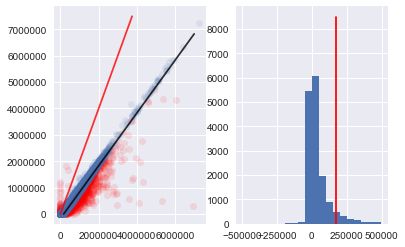

In [6]:
plotting_data = report_payment_data[(report_payment_data['claimed_payment'] < 10000000)]

outliers = plotting_data[plotting_data['over_declaration'] | plotting_data['under_declaration']]
in_control = plotting_data[~ (plotting_data['over_declaration']) & ~(plotting_data['under_declaration'])]

plt.figure(1)
plt.subplot(1,2,1)
plt.plot( outliers.claimed_payment , outliers.verified_payment , 'ro', alpha = 0.1)
plt.plot( in_control.claimed_payment , in_control.verified_payment , 'o' , alpha = 0.1)
plt.plot((0,3750000) , (0,7500000) , 'r-' , alpha = 0.8)
plt.plot((mean_supervision_cost,7000000) , (0,(7000000 - mean_supervision_cost)) , 'k-' , alpha = 0.8)
plotting_data = plotting_data[np.abs(plotting_data['difference_amount']) < 500000]
plt.subplot(1,2,2)
plt.hist(plotting_data[:]['difference_amount'] , bins = 20 )
plt.plot((mean_supervision_cost, mean_supervision_cost), (0, 8500), 'r-')

In [7]:
data_orbf.entity_id.nunique() * mean_supervision_cost  / ((sum(report_payment_data.verified_payment) / 12) + data_orbf.entity_id.nunique() * mean_supervision_cost)

0.12591685239359085

### A classification problem

Based on this first presentation, we want to classify all incoming data in four categories :
1. __In control__ : will be for all the data that seems to follow expected distributions and evolutions
2. __Overestimation__ : will screen and spot the data that seems to be overshooting the expected values by too wide a margin, as previously defined
3. __Underestimation__ : will screen and spot the data that seems to be underevaluating the expected payments by a too wide factor
4. __Quality issue__ : finally, we will aim at identifying reports that seem to show issues in the quality of care in the facility

### Building classification features

To do this classification, we will build features, characterizing the place of the observed values in the expected distributions. We will test 3 approaches to build these features.

The features will need to be built on different dimensions :
1. Internal consistency of each serie : surveillance
2. Facility level consistency with other facilities : hierarchical
3. Profile consistency for the facility / Profile consistency with other facilities

## Surveillance approach

In an Surveillance approach, we will want to monitor the amounts paid to a facility on a monthly basis, and spot a divergence from the expected _in control_ distribution. Methods for this are from a CUSUM family, and use control charts as output to present and interpret the results.

Essentially, in this approach, we want to check if any of the individual observed series in the reports are showing unexpected patterns. To do this, for each facility I will :
1. Model each report serie using an ARIMA based on historic data
2. Get a prediction for the new data
3. Compared the new data to the distribution of expected data 

### Model Fitting

In [8]:
serie_test = data_orbf[(data_orbf.indicator_label == "Nombre de nouvelles acceptances pour les méthodes contraceptives de longue durée(DIU et implant)") & (data_orbf.entity_id == 3)]
#autocorrelation_plot(serie_test.indicator_verified_value)
serie_test = serie_test.set_index('date')

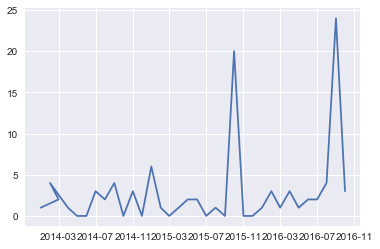

In [9]:
plt.plot(serie_test.indicator_verified_value)

We see no evidence of autocorrelation in this one serie. I thus procede fitting an ARIMA with no autocorrelation

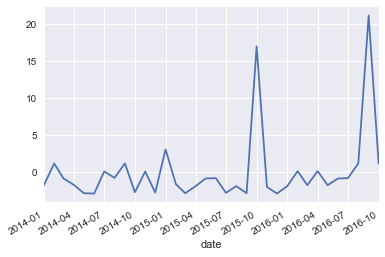

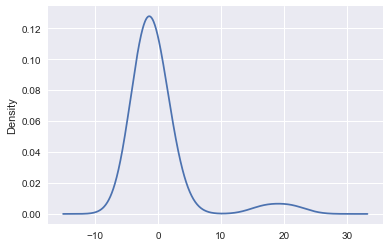

In [10]:
# fit model
model = ARIMA(serie_test.indicator_verified_value, order=(1,0,0))
model_fit = model.fit(disp=0)
#print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot(legend = False)
plt.show()
residuals.plot(kind='kde' , legend = False)
plt.show()
#print(residuals.describe())

In [11]:
X_obs = serie_test.indicator_claimed_value
X_val = serie_test.indicator_verified_value

size = int(len(X_obs) * 0.1)

train, test = X_val[0:size], X_obs[size:len(X_obs)]
verified = X_val[size : len(X_obs)]
history = [x for x in train]
predictions = []
vals = []
z_scores = []
alarms = []

for t in range(len(test)):
    model = ARIMA(history , order=(1,0,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0].tolist()[0]
    predictions.append(yhat)
    obs = test[t]
    z_score = np.abs((yhat - obs) / (model_fit.resid.std()))
    if  z_score < 2:   
        vals.append(obs)
        history.append(obs)
        alarms.append(False)
    if z_score >= 2 :
        vals.append(verified[t])
        history.append(verified[t])
        alarms.append(True)

    z_scores.append(z_score)
error = mean_squared_error(test, predictions)
z_score = np.abs((pd.Series(predictions) - pd.Series(test.tolist())) / (model_fit.resid.std()))
print('Test MSE: %.3f' % error)

Test MSE: 30.274


## Hierarchical modelling

A second approach is to model the values we should observe for different indicators, using 

## Profile monitoring

Finally, we want to check intern consistency of reports. This consistency should be the defined both within facilties and among facilites.

## Classification

## Verification strategies testing

### Different strategies

### Strategy 1 : Complete Supervision

In [17]:
fac_data = data_orbf[data_orbf.entity_id == 34]

### Building the training set :
perc_train = 0.2
TS = create_facility_training_dict(fac_data , perc_train)

test_data = fac_data[~(fac_data.date.isin(TS['train_months']))]
n_periods = test_data.reset_index()['date'].nunique()
strat_1_cost = summary_cost(sum(test_data.indicator_montant) , mean_supervision_cost*n_periods)
print(strat_1_cost)

{'payments': 38929800.0, 'total_cost': 46409800.0, 'perc_supervision': 0.16117285573305637}


### Strategy 2 : Supervision every Cost alerts only

TEMP : Building this functions : what does what

* __TS :__ Keeping track of the training set
* __dict :__ to create, dictionnary with useful indicator info such as tarif, group, ...
* __models :__having methods for running the model / raising alarm etc...
* __out :__ one by model, will keep all the useful outputs by model
* __additional methods :__ for aggregating / displaying the results

In [18]:
tarifs = []
for i in data_orbf.indicator_label.unique() :
    tarifs.append(data_orbf.indicator_tarif[data_orbf.indicator_label == i].tolist()[0])
    
tarifs = pd.Series(tarifs , index = data_orbf.indicator_label.unique())

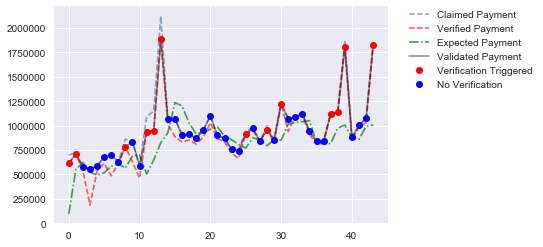

In [50]:
TS = create_facility_training_dict(data_orbf , perc_train)
out = {}
for month in test_data['date'].sort_values().unique():
    ## Initiating the function parameters and output
    dat_month = fac_data[fac_data.date == month].set_index('indicator_label')
    
    ## Screening the data
    arima_screened = arima_report_payment(dat_month , TS)
    
    ## Checking Alarm
    BLIP = overcost_alarm(dat_month.indicator_claimed_value , arima_screened['expected_values'] , tarifs ,
                          mean_supervision_cost , underfunding_max_risk)

    ## Updating the data
    payment_made = make_training_set(TS , dat_month , BLIP)
    
    ## Make the output
    month_char = str(month)[0:7]
    out[month_char] = make_output(dat_month , arima_screened['expected_values'] , payment_made , BLIP)

    
collapsed_output = collapse_output(out , tarifs)
plot_monitoring(collapsed_output)

In [51]:
strat_2_cost = summary_cost(sum(collapsed_output['validated']) , mean_supervision_cost*sum(collapsed_output['alarms']))
print(strat_2_cost)
print(sum(collapsed_output['alarms']) / len(collapsed_output['alarms']))
perc_months_supervisions2 = sum(collapsed_output['alarms']) / len(collapsed_output['alarms'])

{'payments': 41673650.0, 'total_cost': 43883650.0, 'perc_supervision': 0.050360441759060605}
0.295454545455


### Strategy 3 : Supervision for multiple diverging performances

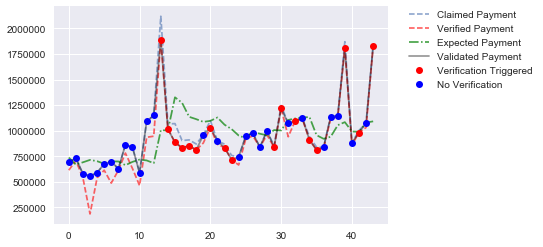

In [52]:
### Building the training set :
TS = create_facility_training_dict(fac_data , perc_train)
out = {}
for month in test_data['date'].sort_values().unique():
    ## Initiating the function parameters and output
    dat_month = fac_data[fac_data.date == month].set_index('indicator_label')
    
    ## Screening the data
    arima_screened = arima_report_payment(dat_month , TS)
    
    z_score = np.abs(dat_month.indicator_claimed_value - arima_screened['expected_values']) / arima_screened['std_vals']
    BLIP = np.nansum(z_score > 2) > 2
    
    ## Updating the data
    payment_made = make_training_set(TS , dat_month , BLIP)
    
    ## Make the output
    month_char = str(month)[0:7]
    out[month_char] = make_output(dat_month , arima_screened['expected_values'] , payment_made , BLIP)

    
collapsed_output = collapse_output(out , tarifs)
plot_monitoring(collapsed_output)

In [53]:
strat_3_cost = summary_cost(sum(collapsed_output['validated']) , mean_supervision_cost*sum(collapsed_output['alarms']))
print(strat_3_cost)
print(sum(collapsed_output['alarms']) / len(collapsed_output['alarms']))
perc_months_supervisions3 = sum(collapsed_output['alarms']) / len(collapsed_output['alarms'])

{'payments': 41665555.0, 'total_cost': 44555555.0, 'perc_supervision': 0.064862843701531711}
0.386363636364


### Comparisons

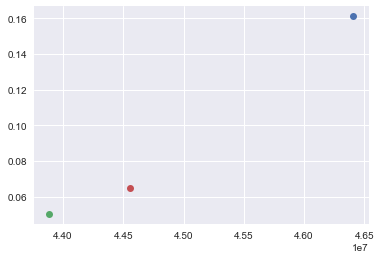

In [44]:
plt.plot(strat_1_cost['total_cost'] , strat_1_cost['perc_supervision'] , 'o')
plt.plot(strat_2_cost['total_cost'] , strat_2_cost['perc_supervision'] , 'o')
plt.plot(strat_3_cost['total_cost'] , strat_3_cost['perc_supervision'] , 'o')

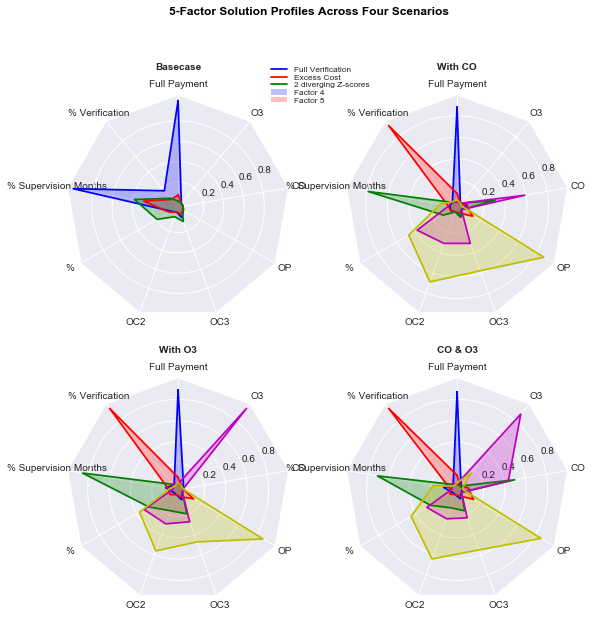

In [57]:
"""
======================================
Radar chart (aka spider or star chart)
======================================

This example creates a radar chart, also known as a spider or star chart [1]_.

Although this example allows a frame of either 'circle' or 'polygon', polygon
frames don't have proper gridlines (the lines are circles instead of polygons).
It's possible to get a polygon grid by setting GRIDLINE_INTERPOLATION_STEPS in
matplotlib.axis to the desired number of vertices, but the orientation of the
polygon is not aligned with the radial axes.

.. [1] http://en.wikipedia.org/wiki/Radar_chart
"""
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib.spines import Spine
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection


def radar_factory(num_vars, frame='circle'):
    """Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle' | 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)
    # rotate theta such that the first axis is at the top
    theta += np.pi/2

    def draw_poly_patch(self):
        verts = unit_poly_verts(theta)
        return plt.Polygon(verts, closed=True, edgecolor='k')

    def draw_circle_patch(self):
        # unit circle centered on (0.5, 0.5)
        return plt.Circle((0.5, 0.5), 0.5)

    patch_dict = {'polygon': draw_poly_patch, 'circle': draw_circle_patch}
    if frame not in patch_dict:
        raise ValueError('unknown value for `frame`: %s' % frame)

    class RadarAxes(PolarAxes):

        name = 'radar'
        # use 1 line segment to connect specified points
        RESOLUTION = 1
        # define draw_frame method
        draw_patch = patch_dict[frame]

        def fill(self, *args, **kwargs):
            """Override fill so that line is closed by default"""
            closed = kwargs.pop('closed', True)
            return super(RadarAxes, self).fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super(RadarAxes, self).plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.concatenate((x, [x[0]]))
                y = np.concatenate((y, [y[0]]))
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            return self.draw_patch()

        def _gen_axes_spines(self):
            if frame == 'circle':
                return PolarAxes._gen_axes_spines(self)
            # The following is a hack to get the spines (i.e. the axes frame)
            # to draw correctly for a polygon frame.

            # spine_type must be 'left', 'right', 'top', 'bottom', or `circle`.
            spine_type = 'circle'
            verts = unit_poly_verts(theta)
            # close off polygon by repeating first vertex
            verts.append(verts[0])
            path = Path(verts)

            spine = Spine(self, spine_type, path)
            spine.set_transform(self.transAxes)
            return {'polar': spine}

    register_projection(RadarAxes)
    return theta


def unit_poly_verts(theta):
    """Return vertices of polygon for subplot axes.

    This polygon is circumscribed by a unit circle centered at (0.5, 0.5)
    """
    x0, y0, r = [0.5] * 3
    verts = [(r*np.cos(t) + x0, r*np.sin(t) + y0) for t in theta]
    return verts


def example_data():
    # The following data is from the Denver Aerosol Sources and Health study.
    # See  doi:10.1016/j.atmosenv.2008.12.017
    #
    # The data are pollution source profile estimates for five modeled
    # pollution sources (e.g., cars, wood-burning, etc) that emit 7-9 chemical
    # species. The radar charts are experimented with here to see if we can
    # nicely visualize how the modeled source profiles change across four
    # scenarios:
    #  1) No gas-phase species present, just seven particulate counts on
    #     Sulfate
    #     Nitrate
    #     Elemental Carbon (EC)
    #     Organic Carbon fraction 1 (OC)
    #     Organic Carbon fraction 2 (OC2)
    #     Organic Carbon fraction 3 (OC3)
    #     Pyrolized Organic Carbon (OP)
    #  2)Inclusion of gas-phase specie carbon monoxide (CO)
    #  3)Inclusion of gas-phase specie ozone (O3).
    #  4)Inclusion of both gas-phase species is present...
    data = [
        ['Full Payment', '% Verification', '% Supervision Months', '% ', 'OC2', 'OC3', 'OP', 'CO', 'O3'],
        ('Basecase', [
            [1, strat_1_cost['perc_supervision'] , 1 , 0.03, 0.00, 0.06, 0.01, 0.00, 0.00],
            [0.07,  strat_2_cost['perc_supervision'], perc_months_supervisions2, 0.05, 0.00, 0.02, 0.01, 0.00, 0.00],
            [0.01, strat_3_cost['perc_supervision'] , perc_months_supervisions3, 0.19, 0.05, 0.10, 0.00, 0.00, 0.00]]),
        ('With CO', [
            [0.88, 0.02, 0.02, 0.02, 0.00, 0.05, 0.00, 0.05, 0.00],
            [0.08, 0.94, 0.04, 0.02, 0.00, 0.01, 0.12, 0.04, 0.00],
            [0.01, 0.01, 0.79, 0.10, 0.00, 0.05, 0.00, 0.31, 0.00],
            [0.00, 0.02, 0.03, 0.38, 0.31, 0.31, 0.00, 0.59, 0.00],
            [0.02, 0.02, 0.11, 0.47, 0.69, 0.58, 0.88, 0.00, 0.00]]),
        ('With O3', [
            [0.89, 0.01, 0.07, 0.00, 0.00, 0.05, 0.00, 0.00, 0.03],
            [0.07, 0.95, 0.05, 0.04, 0.00, 0.02, 0.12, 0.00, 0.00],
            [0.01, 0.02, 0.86, 0.27, 0.16, 0.19, 0.00, 0.00, 0.00],
            [0.01, 0.03, 0.00, 0.32, 0.29, 0.27, 0.00, 0.00, 0.95],
            [0.02, 0.00, 0.03, 0.37, 0.56, 0.47, 0.87, 0.00, 0.00]]),
        ('CO & O3', [
            [0.87, 0.01, 0.08, 0.00, 0.00, 0.04, 0.00, 0.00, 0.01],
            [0.09, 0.95, 0.02, 0.03, 0.00, 0.01, 0.13, 0.06, 0.00],
            [0.01, 0.02, 0.71, 0.24, 0.13, 0.16, 0.00, 0.50, 0.00],
            [0.01, 0.03, 0.00, 0.28, 0.24, 0.23, 0.00, 0.44, 0.88],
            [0.02, 0.00, 0.18, 0.45, 0.64, 0.55, 0.86, 0.00, 0.16]])
    ]
    return data


if __name__ == '__main__':
    N = 9
    theta = radar_factory(N, frame='polygon')

    data = example_data()
    spoke_labels = data.pop(0)

    fig, axes = plt.subplots(figsize=(9, 9), nrows=2, ncols=2,
                             subplot_kw=dict(projection='radar'))
    fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)

    colors = ['b', 'r', 'g', 'm', 'y']
    # Plot the four cases from the example data on separate axes
    for ax, (title, case_data) in zip(axes.flatten(), data):
        ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
        ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.1),
                     horizontalalignment='center', verticalalignment='center')
        for d, color in zip(case_data, colors):
            ax.plot(theta, d, color=color)
            ax.fill(theta, d, facecolor=color, alpha=0.25)
        ax.set_varlabels(spoke_labels)

    # add legend relative to top-left plot
    ax = axes[0, 0]
    labels = ('Full Verification', 'Excess Cost', '2 diverging Z-scores', 'Factor 4', 'Factor 5')
    legend = ax.legend(labels, loc=(0.9, .95),
                       labelspacing=0.1, fontsize='small')

    fig.text(0.5, 0.965, '5-Factor Solution Profiles Across Four Scenarios',
             horizontalalignment='center', color='black', weight='bold',
             size='large')

    plt.show()